<h1>Deep learning models for sentiment analysis.<br/>


<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTHcPmimTJL2f4KBVmtG3QPYjHgVVGDoywevA&usqp=CAU" width="333" class="center"/>

This notebook aims to show how it is possible to solve the problem of classification into positive and negative feelings. I'm going to start by presenting the data that we're going to study. Then explain the principles of tokenization. Then I will present four models using deep learning methods. To finally use these four models in a single prediction. The  models will be created with pytorch.



### Table of Contents

* <a href="#Presentation of data.">Presentation of data.</a>
* <a href="#GLOVE Pretrained Emebedding">GLOVE Pretrained Emebedding</a>
* <a href="#LSTM Clasifier">LSTM Clasifier</a>
* <a href="#Fine tuning BERT">Fine tuning BERT</a>
* <a href="#Fine tuning XLNET">Fine tuning XLNET</a>
* <a href="#Model comparison.">Model comparison.</a>

### Indications before running the notebook.

* You will only be able to run this notebook if you have a GPU, so if your computer does not have one you can go to Google Colaboratory to get access to a GPU. In the code below I assume that you have your notebook on google colaboratory and that you have modified the type of execution to activate a GPU. If so, you should see "Device: cuda" as a message.
* Also I assume you have downloaded imdb dataset locally. If this is the case you will need to modify ```path_data``` so that it indicates the position of the data.



In [ ]:
from google.colab import drive
import torch 

drive.mount('/content/drive')
path_data="/content/drive/My Drive/IPP-M2-DS/Deep with python/Project IMDB/Data/IMDB Dataset.csv"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device :",device)

Mounted at /content/drive
Device : cuda


concerning the packages you will have to install two packages on google colaboratory with the following commands:

In [ ]:
#!pip install transformers
#!pip install datasets

In [ ]:
import os
from tqdm import tqdm, trange
import random
import time
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import math
import time
import pprint
pp = pprint.PrettyPrinter()
import numpy as np
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from torchtext.legacy import data
from torchtext.data.utils import get_tokenizer

import torch.nn as nn

from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, get_scheduler
from transformers import XLNetConfig,AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from datasets import Dataset, load_dataset, load_metric

from keras.preprocessing.sequence import pad_sequences


The results dictionary will allow you to store the results as the experiments progress.


In [ ]:
results={}
models_name = ["BERT","XLNET","LSTM","GLOVE"]
for model_name in models_name:
  results[model_name] = {"Train Loss":[],"Train Acc":[],"Val. Loss": [],"Val. Acc":[],"test. Acc":0,"test. loss":0,"Training time":0}

EPOCH_NUMBER = 12

<a id="Functions"></a>
# Functions

During this notebook we will use 3 main functions. One for model training (```train```). One for validation (```evaluate```) and finally one to visualize the performance (```plot_results```) of our models. Note that the train and validation function takes the model you want to train as an argument. We do this because the 4 models do not have exactly the same types of arguments for training and they do not use the same dataloader.


In [ ]:
def train(model,iterator,optimizer,criterion, train_glove=False,train_LSTM=False,train_pretrain=False):
  torch.cuda.empty_cache()
  epoch_loss = 0.0
  epoch_acc = 0.0
  
  model.train()
  metric = load_metric("accuracy")
  for batch in iterator:
      optimizer.zero_grad()

      if train_LSTM:

        text,text_lengths = batch.review
        predictions = model(text,text_lengths).squeeze()
        loss = criterion(predictions,batch.sentiment)

        correct = (torch.round(predictions) == batch.sentiment).float() 
        acc = correct.sum() / len(correct)


        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss.backward()
        optimizer.step()


      if train_glove:

        text,text_lengths = batch.review
        predictions = model(text).squeeze()
        loss = criterion(predictions,batch.sentiment)

        correct = (torch.round(predictions) == batch.sentiment).float() 
        acc = correct.sum() / len(correct)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss.backward()
        optimizer.step()


      if train_pretrain:
        
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        predictions = outputs.logits
        predictions = torch.argmax(predictions, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
        epoch_loss += loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

  if  train_pretrain:
     return epoch_loss / len(iterator), metric.compute()["accuracy"]

  if not train_pretrain:
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model,iterator,criterion, train_glove=False,train_LSTM=False,train_pretrain=False):

    epoch_loss = 0.0
    epoch_acc = 0.0
    
    # deactivate the dropouts
    model.eval()
    metric = load_metric("accuracy")
    # Sets require_grad flat False
    with torch.no_grad():
        for batch in iterator:
            if train_LSTM:

              text,text_lengths = batch.review
              predictions = model(text,text_lengths).squeeze()
              loss = criterion(predictions,batch.sentiment)

              correct = (torch.round(predictions) == batch.sentiment).float() 
              acc = correct.sum() / len(correct)

              epoch_loss += loss.item()
              epoch_acc += acc.item()

            if train_glove:

              text,text_lengths = batch.review
              predictions = model(text).squeeze()
              loss = criterion(predictions,batch.sentiment)

              correct = (torch.round(predictions) == batch.sentiment).float() 
              acc = correct.sum() / len(correct)

              epoch_loss += loss.item()
              epoch_acc += acc.item()

            if train_pretrain:
              
              batch = {k: v.to(device) for k, v in batch.items()}
              outputs = model(**batch)
              loss = outputs.loss
              predictions = outputs.logits
              
              predictions = torch.argmax(predictions, dim=-1)

              lr_scheduler.step()
              metric.add_batch(predictions=predictions, references=batch["labels"])




              epoch_loss += loss
    if  train_pretrain:
      return epoch_loss / len(iterator), metric.compute()["accuracy"]
    if not train_pretrain:
      return epoch_loss / len(iterator), epoch_acc / len(iterator)

def plot_results(model_name):
  plt.style.use("seaborn")
  fig, (ax1,ax2) = plt.subplots(2,sharex=True)
  ax1.set_title(model_name,fontsize=18,fontstyle='italic')

  ax1.plot(results[model_name]["Train Acc"],label="Train Acc",linewidth=3)
  ax1.plot(results[model_name]["Val. Acc"],label="Val. Acc",linewidth=3)
  ax1.legend(loc='upper left', shadow=True)
  ax1.set_xlabel('EPOCHS')
  ax1.set_ylabel('Accuracy')

  ax2.plot(results[model_name]["Train Loss"],label="Train Loss",linewidth=3)
  ax2.plot(results[model_name]["Val. Loss"],label="Val. Loss",linewidth=3)
  ax2.legend(loc='upper left', shadow=True)
  ax2.set_xlabel('EPOCHS')
  ax2.set_ylabel('Loss')

  fig.set_figheight(12.3)
  fig.set_figwidth(10)

# Presentation of data.


In [ ]:
df = pd.read_csv(path_data)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
pp.pprint(df.loc[0]["review"])
print("Sentiment :",df.loc[0]["sentiment"])

('One of the other reviewers has mentioned that after watching just 1 Oz '
 "episode you'll be hooked. They are right, as this is exactly what happened "
 'with me.<br /><br />The first thing that struck me about Oz was its '
 'brutality and unflinching scenes of violence, which set in right from the '
 'word GO. Trust me, this is not a show for the faint hearted or timid. This '
 'show pulls no punches with regards to drugs, sex or violence. Its is '
 'hardcore, in the classic use of the word.<br /><br />It is called OZ as that '
 'is the nickname given to the Oswald Maximum Security State Penitentary. It '
 'focuses mainly on Emerald City, an experimental section of the prison where '
 'all the cells have glass fronts and face inwards, so privacy is not high on '
 'the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, '
 'Christians, Italians, Irish and more....so scuffles, death stares, dodgy '
 'dealings and shady agreements are never far away.<br /><br />I would

We have the same number of positive and negative reviews, a balanced dataset. We can use the accuracy to compare our results.


In [ ]:
df["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
df.shape

(50000, 2)

# GLOVE PRETRAINED EMBEDDING

[GLOVE](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation) is a word embedding that was created in 2014 by researchers from Stanford Univeristy. The idea of ​​word embedding is to capture the semantics of a word inside a vector. So two close words in the language are expected to have a close embedding as well. As explained in their [paper](https://nlp.stanford.edu/pubs/glove.pdf). An embedding is expected to capture complex relationships, such as the distance between the male and female vectors being the same as the distance between the king and queen vectors: vec(king) −
vec(queen) = vec(man) − vec(woman). As we can see below glove is able to create the embedding of 400000 words, for vectors of size 300. Like wor2vec GLOVE is a log-bilinear language model. It is trained to predict the next word using previous words. But instead of using the co-occurence matrix as is the case for word2vec, it will use an improved version of this matrix. The idea is to use a ratio of these co-occurence probability, instead of just co-occurences.








In [ ]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
print("GLOVE size : ",loaded_glove_model.vectors.shape)

[==================================================] 100.0% 376.1/376.1MB downloaded
GLOVE size :  (400000, 300)


We can see in the example below how glove works. Here I first recovered the vectors of size 300 then I applied a pca to keep only two main axes (of maximum variance). We can clearly see that the distance between the masculine word and its feminine equivalent are almost always at the same distance.


['man',
 'woman',
 'king',
 'queen',
 'sister',
 'brother',
 'empress',
 'emperor',
 'aunt',
 'uncle']


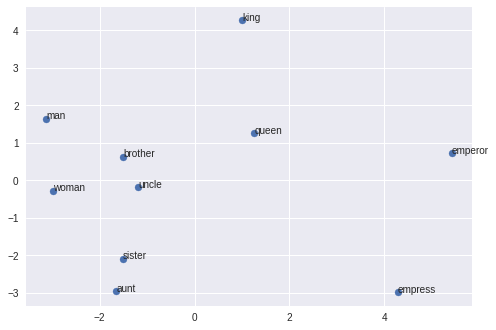

In [ ]:
words=["man","woman","king","queen","sister","brother","empress","emperor","aunt","uncle"]
pp.pprint(words)
training_word2idx = dict(zip(words,range(len(words))))
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
pca = PCA(n_components=2)
reduce_embedding = pca.fit_transform(GloveEmbeddings[range(len(words))])

plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.scatter(reduce_embedding[:,0], reduce_embedding[:,1])
for i, txt in enumerate(training_word2idx.keys()):
    ax.annotate(txt, (reduce_embedding[:,0][i], reduce_embedding[:,1][i]))

The idea of ​​a tokenizer is to take a text as input and give us the associated tokens. The choice of tokens varies according to the models. Generally, we have a token when we have a space in a sentence. Thus a word corresponds to a token just like a punctuation. However, this definition suffers from many problems, such as compound words. Air France does not have the same meaning as Air and France. During this notebook we will use popular tokenizers in order to guarantee the quality of the tokens created. In the example below, I import the spacy tokenizer and I give an example of what we get by applying it to the first document of the IMDB dataset.



In [ ]:
tokenizer = get_tokenizer('spacy')
pp.pprint(tokenizer(df.loc[0]["review"])[:18])

['One',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching',
 'just',
 '1',
 'Oz',
 'episode',
 'you',
 "'ll",
 'be',
 'hooked']


To simplify learning we will use dataloaders for training. A train dataloader, test and validate. In order to compare the models we will always use 25000 data to test our model, 20000 to train it and 5000 to validate.


In [ ]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
fields = [('review',TEXT),("sentiment",LABEL)]
training_data = data.TabularDataset(path=path_data,
                                    format="csv",
                                    fields=fields,
                                    skip_header=True
                                   )

train_data,test_data = training_data.split(split_ratio=0.5)
train_data,valid_data = train_data.split(split_ratio=0.8)
TEXT.build_vocab(train_data,min_freq=5)
LABEL.build_vocab(train_data)
BATCH_SIZE = 32
train_iterator = data.BucketIterator(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        repeat=False,
        sort=False,
        device = device)

test_iterator = data.BucketIterator(
        dataset=test_data,
        batch_size=BATCH_SIZE,
        repeat=False,
        sort=False,
        device = device)

validation_iterator = data.BucketIterator(
        dataset=valid_data,
        batch_size=BATCH_SIZE,
        repeat=False,
        sort=False,
        device = device)
print("Train size = {}, Test size = {}, valid size = {}".format(len(train_data),len(test_data),len(valid_data)))

Train size = 20000, Test size = 25000, valid size = 5000


For our model, we will take the GLOVE embedding that we will fine tune to adapt it to our data. To do so, we specify requires_grad=True. Then we will average the embeddings for our document, which will allow us to obtain a vector of size 300 for each document. Then we will simply use this vector of size 300 as input to a linear model and end with a sigmoid activation to have a probability between 0 and 1 as output.


In [ ]:
class PretrainedAveragingModel(nn.Module):

    def __init__(self, embedding_dim, vocabulary_size,pretrained_embeddings,fine_tuning):
      super().__init__()
      self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1,embedding_dim=embedding_dim)
      self.embeddings.from_pretrained(pretrained_embeddings)
      self.embeddings.weight.requires_grad=fine_tuning
      self.linear = nn.Linear(in_features=embedding_dim,out_features=1) 
      self.act = nn.Sigmoid()
      
    def forward(self, inputs):
        x =  torch.mean(self.embeddings(inputs),1) 
        o = self.linear(x)
        o = self.act(o)
        return o

How we are on a binary classification problem we will use the binary cross entropy as loss. For the optimization we use ADAM.


In [ ]:
training_word2idx = TEXT.vocab.stoi
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
criterion = nn.BCELoss().to(device)
model_pre_trained = PretrainedAveragingModel(300, len(training_word2idx), torch.FloatTensor(GloveEmbeddings), True).to(device)
opt_pre_trained = optim.Adam(model_pre_trained.parameters(), lr=0.0025, betas=(0.9, 0.999))

During the training of each model, we will save the results in the results dictionary. For each epoch we will train on the dataloader train and validate on the dataloader val. Then when the training is finished we will test our results on test dataloader. Time is also saved to compare this aspect also of the different models.


In [ ]:
EPOCH_NUMBER=8
start = time.time()
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc = train(model_pre_trained,train_iterator,opt_pre_trained,criterion,train_glove=True)
    valid_loss,valid_acc = evaluate(model_pre_trained,validation_iterator,criterion,train_glove=True)
    
    results["GLOVE"]["Train Loss"].append(train_loss)
    results["GLOVE"]["Train Acc"].append(train_acc*100)
    results["GLOVE"]["Val. Loss"].append(valid_loss)
    results["GLOVE"]["Val. Acc"].append(valid_acc*100)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

test_loss,test_acc = evaluate(model_pre_trained,test_iterator,criterion,train_glove=True)
print(f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc*100:.2f}%')
stop = time.time()
print(f"\t Training time: {stop - start}s")
results["GLOVE"]["Training time"] = stop - start
results["GLOVE"]["test. loss"] = test_loss
results["GLOVE"]["test. Acc"] = test_acc

	 Epoch: 1
	Train Loss: 0.627 | Train Acc: 64.94%
	 Val. Loss: 0.506 |  Val. Acc: 81.43%

	 Epoch: 2
	Train Loss: 0.408 | Train Acc: 84.58%
	 Val. Loss: 0.361 |  Val. Acc: 87.36%

	 Epoch: 3
	Train Loss: 0.297 | Train Acc: 89.41%
	 Val. Loss: 0.319 |  Val. Acc: 88.36%

	 Epoch: 4
	Train Loss: 0.239 | Train Acc: 91.94%
	 Val. Loss: 0.299 |  Val. Acc: 88.69%

	 Epoch: 5
	Train Loss: 0.199 | Train Acc: 93.51%
	 Val. Loss: 0.287 |  Val. Acc: 89.57%

	 Epoch: 6
	Train Loss: 0.170 | Train Acc: 94.32%
	 Val. Loss: 0.301 |  Val. Acc: 88.71%

	 Epoch: 7
	Train Loss: 0.141 | Train Acc: 95.71%
	 Val. Loss: 0.303 |  Val. Acc: 88.71%

	 Epoch: 8
	Train Loss: 0.125 | Train Acc: 96.16%
	 Val. Loss: 0.304 |  Val. Acc: 87.98%

	 test. Loss: 0.311 |  test. Acc: 88.18%
	 Training time: 98.85434031486511s


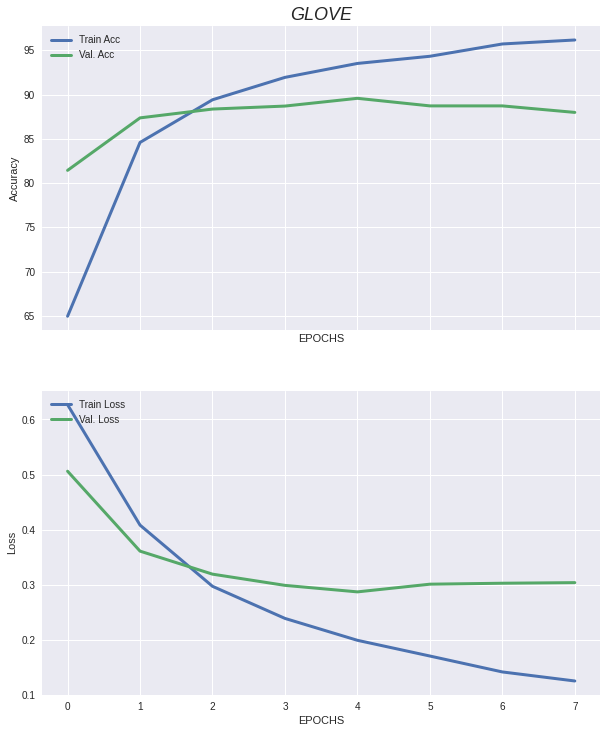

In [ ]:
plot_results("GLOVE")

After 145 seconds of training we obtain an accuracy on the 25000 data (test sample) of 88% which is quite good.


# LSTM CLASSIFIER

Unlike the previous model here, we will start from a randomly initialized embedding that we will train. We will also use a bidirectional LSTM. The second layer use the pack_padded_sequence function. without going into too much detail, the idea of ​​this function is to save calculation time but will not influence the result. As you can see this model uses an LSTM layer.


 With pytorch the lstm layer returns a lot of information to us, it is not always easy to see clearly which one to use. As a reminder, one of the problems with RNNs comes from gradient backpropagation. When the chain is too large, the gradient tends either to explode or to disappear, which makes learning long-term relationships very complicated for this type of model. Hence the interest of using an LSTM. The LSTM will solve this problem by having a long-term memory. Thus LSTM receives three sources of information at the input of each cell, the data, the short-term memory which is recorded in the hidden states and the long-term memory which is recorded in the cell states. The LSTM cell will also return three items.

* output : which is composed of all the hidden states in the last layer.
* hidden : hidden state which contains information about the previous time step.
* Cell : cell which contains information about all previous information in the sentence.



We will also use a bidirectional LSTM. The idea is that we will pass the data in one direction but also in the other. Thus we will use the information contained in the past and the future to predict the words. By having a bidirectional LSTM we will therefore have two hidden states. One for the forward part and the other for the backward part of the LSTM (nothing to do with the gradient here). We will retrieve the last hidden states from the forward and backward part that we will concatenate before using it as features in a fully connected layer.









In [ ]:

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True,enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        return outputs

In [ ]:
model = classifier (vocab_size=len(TEXT.vocab),
                    embedding_dim=100,
                    hidden_dim=63,
                    output_dim=1,
                    n_layers=2,
                    bidirectional=True,
                    dropout=0.2).to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
start =time.time()
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc = train(model,train_iterator,optimizer,criterion,train_LSTM=True)
    valid_loss,valid_acc, _  = evaluate(model,validation_iterator,criterion,train_LSTM=True)
  
    results["LSTM"]["Train Loss"].append(train_loss)
    results["LSTM"]["Train Acc"].append(train_acc*100)
    results["LSTM"]["Val. Loss"].append(valid_loss)
    results["LSTM"]["Val. Acc"].append(valid_acc*100)
    # Showing statistics
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

test_loss,test_acc = evaluate(model,test_iterator,criterion,train_LSTM=True)
print(f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc*100:.2f}%')

stop = time.time()
print(f"\t Training time: {stop - start}s")
results["LSTM"]["Training time"] = stop - start
results["LSTM"]["test. loss"] = test_loss
results["LSTM"]["test. Acc"] = test_acc

	 Epoch: 1
	Train Loss: 0.687 | Train Acc: 55.77%
	 Val. Loss: 0.669 |  Val. Acc: 60.75%

	 Epoch: 2
	Train Loss: 0.588 | Train Acc: 68.70%
	 Val. Loss: 0.543 |  Val. Acc: 72.29%

	 Epoch: 3
	Train Loss: 0.488 | Train Acc: 76.70%
	 Val. Loss: 0.472 |  Val. Acc: 77.51%

	 Epoch: 4
	Train Loss: 0.428 | Train Acc: 80.59%
	 Val. Loss: 0.466 |  Val. Acc: 77.59%

	 Epoch: 5
	Train Loss: 0.382 | Train Acc: 83.32%
	 Val. Loss: 0.422 |  Val. Acc: 81.71%

	 Epoch: 6
	Train Loss: 0.352 | Train Acc: 84.95%
	 Val. Loss: 0.381 |  Val. Acc: 83.42%

	 Epoch: 7
	Train Loss: 0.314 | Train Acc: 86.94%
	 Val. Loss: 0.371 |  Val. Acc: 84.18%

	 Epoch: 8
	Train Loss: 0.288 | Train Acc: 88.27%
	 Val. Loss: 0.366 |  Val. Acc: 85.11%

	 Epoch: 9
	Train Loss: 0.263 | Train Acc: 89.41%
	 Val. Loss: 0.391 |  Val. Acc: 84.00%

	 Epoch: 10
	Train Loss: 0.241 | Train Acc: 90.42%
	 Val. Loss: 0.364 |  Val. Acc: 85.55%

	 Epoch: 11
	Train Loss: 0.225 | Train Acc: 91.18%
	 Val. Loss: 0.423 |  Val. Acc: 84.38%

	 Epoch:

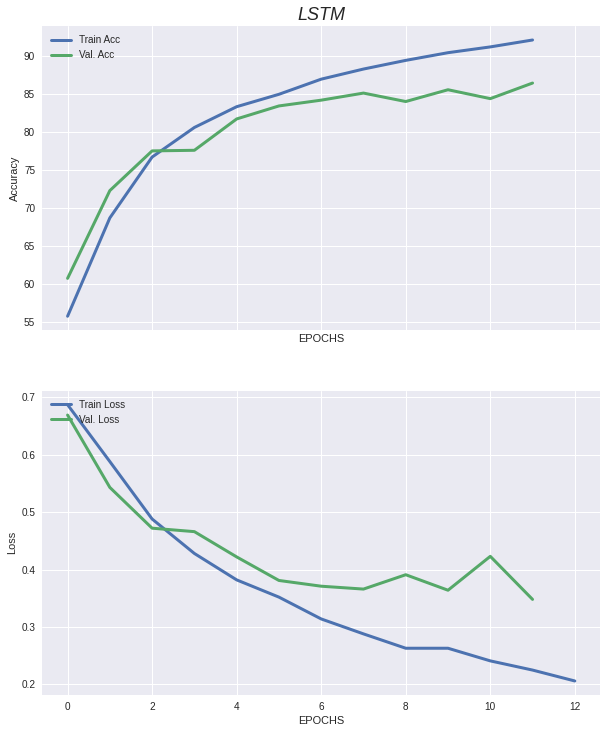

In [ ]:
plot_results("LSTM")

We see that the use of an LSTM layer does not necessarily improve our model if we compare it to GLOVE. There is also a very significant increase in computation times.


# Fine tuning

As we had fine tune GLOVE to fit our data. We will now fine tune the models. We are going to look at two more complex models now and see if their use really makes sense in the case of a dataset like IMDB Dataset. During this part on fine tuning we will focus on two well-known models [BERT](https://arxiv.org/pdf/1810.04805.pdf) and [XLNET](https://arxiv.org/pdf/1906.08237.pdf). To fine tune these models we will use the very practical "transformers" library of [hugging face](https://huggingface.co/). 




I'll start by quickly explaining what a transformer is. Transformers were proposed in 2017 in this [paper](https://arxiv.org/pdf/1706.03762.pdf), and have since been state-of-the-art in NLP. They are the state of the art in all the tasks of NLP which was until then mainly dominated by LSTMs and RNNs. In addition, the great progress of these models is that it will take the entire sentence as input and no longer sequentially as before. This will greatly improve computation times. 




In [ ]:
model_max_length=128
batch_size=32
EPOCH_NUMBER=8

# XLNET

In the family of transformers there are a large number of different architectures. One of the most popular is XLNET. The idea of ​​this method is to calculate the probability of a word based on all the permutations of all the other words in the sentence. Here we don't use the right and left context as an LSTM but we use permutations of words as context to predict a word.


As I use the transformer library for this fine tuning part. I have to re-create my dataloaders. I will therefore use the same distribution train, test, valid.


In [ ]:
raw_datasets = load_dataset('csv', data_files=path_data)
raw_datasets["train"]= raw_datasets["train"].add_column("labels", pd.Series(raw_datasets["train"]["sentiment"]).map({'negative':0,'positive':1}).tolist())
raw_datasets=raw_datasets["train"].train_test_split(0.5)
raw_data_valid = raw_datasets["train"].train_test_split(0.2)
raw_datasets["train"]= raw_data_valid["train"]
raw_datasets["valid"]= raw_data_valid["test"]
raw_datasets

Using custom data configuration default-8ae4b7f686e27f43


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8ae4b7f686e27f43/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 25000
    })
    valid: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 5000
    })
})

Also the tokenizer that must be used is the one associated with XLNET. Indeed, as we are going to use an already trained model, it must take as input the same type of tokens, but also the same coding of a word to a number. For this we use AutoTokenizer.from_pretrained which allows to load the tokenizer.


In [ ]:
def tokenize_function(example):
    return tokenizer(example["review"], truncation=True)

tokenizer  = AutoTokenizer.from_pretrained("xlnet-base-cased",model_max_length=model_max_length)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets = tokenized_datasets.remove_columns(["review","sentiment"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

As we can see the tokenizer sends us several new elements
* ```input_ids``` : As before, input_ids corresponds to the tokens that we replaced with a number to give it as input to our model.
* ```token_type_ids``` : Token type ids has an operation directly linked to the training of the XLNET model. During its training we said that XLNET should predict the next words using the permutations of all the other words. That's true, but that's not the only problem this model has to solve. The second task concerns a pair of sentences that we will give him as input and of which he will have to say whether they are in the right order or not. This parameter is used to indicate for the value 0 it is the first sentence the value 1 is the second and the value 2 is the end of sentence token. As here we don't have this type of objective, we are not interested in this vector.
* ```attention_mask``` : This vector allows to know if my sequence has been received a padding or not. Here as we took sequences of size 128 we have almost none of our sequences that had a padding. As our sequences almost never have any padding, we have a vector with only 1s, if we had the last 10 values ​​that had been padded, we would have had 10 0s at the end of this vector.


In [ ]:
tokenized_datasets["train"]["input_ids"][0]

tensor([  394,    25,    71,    19,  2479,  5529,   408,    30,    24, 24264,
           19,    21,  9920,  1432,     9,   183,    44,   210, 10819,    19,
         8612,    19,    21,  8340,    19,    52,  1432,    26,    23,   345,
           36,     9,   183,    44,    26,    88,    24,  3054,    20,    18,
         1160,    17,    10,  1970,    35,   569,    11,    44,  1508,   178,
          175,   160,    36,  4150,     9,   130,   108,    44,   220,    26,
           46,    19,    49,   112,    21,   210,    22,  1628,    36,  4207,
           19,    35,  3877,  4412,    52,  1432,     9,  2187,  1352,  1199,
           21,  7362,  5153,    41,    24, 24264,  2729,    33,   312, 10421,
            9,   476,    19,    35,  1732,    26,    46,  4412,    52,  1432,
           22,  7497,  3567,  7585,     9,   201,    47,    22,  1111,   131,
          166,   104,    41,  2882,    22,    39,   834,    40,    19,    21,
          114,    24,  7214,    20,   211,    41,     4,     3])

In [ ]:
tokenized_datasets["train"]["token_type_ids"][0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2])

In [ ]:
tokenized_datasets["train"]["attention_mask"][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], batch_size=batch_size, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=0,num_training_steps=EPOCH_NUMBER * len(train_dataloader),)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
start = time.time()
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc = train(model,train_dataloader,optimizer,None,train_pretrain=True)
    valid_loss,valid_acc = evaluate(model,eval_dataloader,None,train_pretrain=True)
    
    results["XLNET"]["Train Loss"].append(train_loss.cpu().detach().numpy())
    results["XLNET"]["Train Acc"].append(train_acc*100)
    results["XLNET"]["Val. Loss"].append(valid_loss.cpu().detach().numpy())
    results["XLNET"]["Val. Acc"].append(valid_acc*100)
    # Showing statistics
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

test_loss,test_acc = evaluate(model,test_dataloader,None,train_pretrain=True)
print(f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc*100:.2f}%')
stop = time.time()
print(f"\t Training time: {stop - start}s")
results["XLNET"]["Training time"] = stop - start
results["XLNET"]["test. loss"] = test_loss
results["XLNET"]["test. Acc"] = test_acc



	 Epoch: 1
	Train Loss: 0.315 | Train Acc: 86.46%
	 Val. Loss: 0.255 |  Val. Acc: 89.46%

	 Epoch: 2
	Train Loss: 0.193 | Train Acc: 92.45%
	 Val. Loss: 0.255 |  Val. Acc: 89.66%

	 Epoch: 3
	Train Loss: 0.098 | Train Acc: 96.34%
	 Val. Loss: 0.322 |  Val. Acc: 89.72%

	 Epoch: 4
	Train Loss: 0.047 | Train Acc: 98.39%
	 Val. Loss: 0.437 |  Val. Acc: 89.26%

	 Epoch: 5
	Train Loss: 0.020 | Train Acc: 99.38%
	 Val. Loss: 0.517 |  Val. Acc: 89.74%

	 Epoch: 6
	Train Loss: 0.009 | Train Acc: 99.73%
	 Val. Loss: 0.582 |  Val. Acc: 90.46%

	 Epoch: 7
	Train Loss: 0.004 | Train Acc: 99.89%
	 Val. Loss: 0.597 |  Val. Acc: 90.30%

	 Epoch: 8
	Train Loss: 0.004 | Train Acc: 99.91%
	 Val. Loss: 0.597 |  Val. Acc: 90.30%

	 test. Loss: 0.607 |  test. Acc: 89.73%
	 Training time: 3046.756291627884s


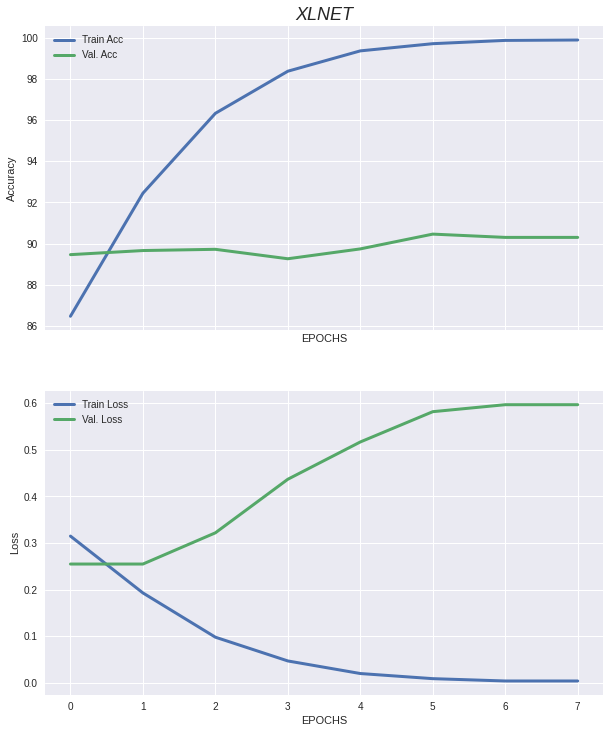

In [ ]:
plot_results("XLNET")

There are several interesting things; On the one hand we see that we have put too many EPOCHS, for this type of stain 2 epochs would have been enough for our model. We see that we obtain better performances than with GLOVE but we have improved our results very little compared to the time our model took to train..


# BERT

BERT is probably the most popular transformer. It has long been the most efficient model. His strongest idea was to modify the way of training the model. Like XLNET, it is trained on two tasks. One is for sentence pairs like XLNET. Bert is trained to predict whether the second sentence is the sentence following the first in the original text. This type of training is called next sentence prediction NSP. But what made BERT known is above all the second task on which he trains. The idea is to mask a certain percentage of input tokens and train the model to predict these tokens using all unmasked tokens. in the figure below taken from the original paper. We can actually see these two spots on the figure on the left. On the figure on the right are examples of possible fine-tuning on three different datasets.






<img src="https://miro.medium.com/max/1400/1*bYO5tEcRzdHtjHV_P6-4ig.png" width="800" class="center"/>





In [ ]:
tokenizer  = AutoTokenizer.from_pretrained("bert-base-cased",model_max_length=model_max_length)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets = tokenized_datasets.remove_columns(["review","sentiment"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], batch_size=batch_size, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=0,num_training_steps=EPOCH_NUMBER * len(train_dataloader))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
start=time.time()
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc = train(model,train_dataloader,optimizer,None,train_pretrain=True)
    valid_loss,valid_acc = evaluate(model,eval_dataloader,None,train_pretrain=True)
    
    results["BERT"]["Train Loss"].append(train_loss.cpu().detach().numpy())
    results["BERT"]["Train Acc"].append(train_acc*100)
    results["BERT"]["Val. Loss"].append(valid_loss.cpu().detach().numpy())
    results["BERT"]["Val. Acc"].append(valid_acc*100)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

test_loss,test_acc = evaluate(model,test_dataloader,None,train_pretrain=True)
print(f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc*100:.2f}%')
stop = time.time()
print(f"\t Training time: {stop - start}s")
results["BERT"]["Training time"] = stop - start
results["BERT"]["test. loss"] = test_loss
results["BERT"]["test. Acc"] = test_acc

	 Epoch: 1
	Train Loss: 0.390 | Train Acc: 81.99%
	 Val. Loss: 0.314 |  Val. Acc: 86.20%

	 Epoch: 2
	Train Loss: 0.215 | Train Acc: 91.59%
	 Val. Loss: 0.342 |  Val. Acc: 86.62%

	 Epoch: 3
	Train Loss: 0.099 | Train Acc: 96.69%
	 Val. Loss: 0.414 |  Val. Acc: 87.46%

	 Epoch: 4
	Train Loss: 0.046 | Train Acc: 98.67%
	 Val. Loss: 0.465 |  Val. Acc: 87.66%

	 Epoch: 5
	Train Loss: 0.022 | Train Acc: 99.41%
	 Val. Loss: 0.522 |  Val. Acc: 88.18%

	 Epoch: 6
	Train Loss: 0.012 | Train Acc: 99.74%
	 Val. Loss: 0.605 |  Val. Acc: 88.38%

	 Epoch: 7
	Train Loss: 0.007 | Train Acc: 99.85%
	 Val. Loss: 0.614 |  Val. Acc: 88.24%

	 Epoch: 8
	Train Loss: 0.007 | Train Acc: 99.84%
	 Val. Loss: 0.614 |  Val. Acc: 88.24%

	 test. Loss: 0.618 |  test. Acc: 87.97%
	 Training time: 2207.9460191726685s


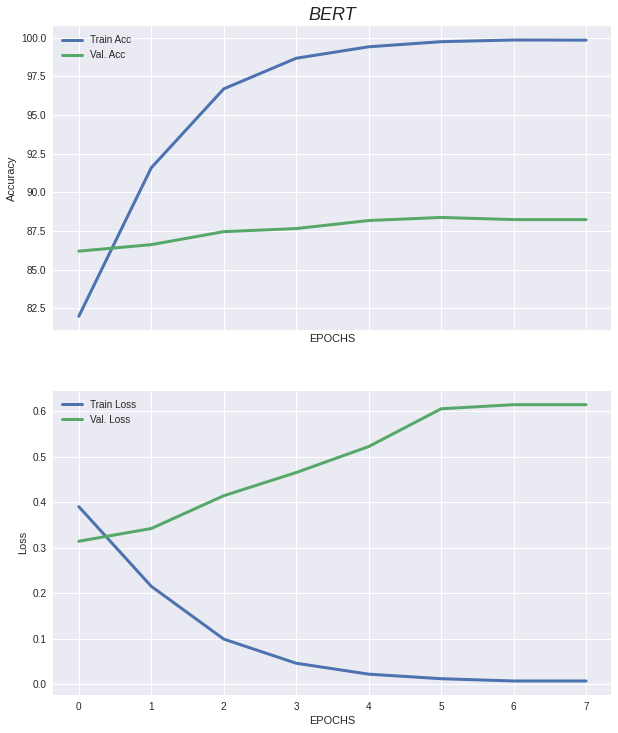

In [ ]:
plot_results('BERT')

As before, we have a model that was trained on an epochs top. We see that two was enough. It obtains good performances compared to LSTM but is worse than GLOVE. 

In [ ]:
with open('results_imdb.pkl', 'wb') as f:
    pickle.dump(results, f)        


In [ ]:
with open('results_imdb.pkl', 'rb') as f:
    results = pickle.load(f)

# Results

Overall we notice that it was not necessary to use complex torp models for this type of stains, we only gain a few percentages of accuracy but we lose a lot of calculation time.


In [ ]:
time_and_test = np.zeros((4,3))
for i in range(4):
  for idx,j in enumerate(["Training time",'test. Acc','test. loss']):
    time_and_test[i,idx]=results[models_name[i]][j]
time_and_test = pd.DataFrame(time_and_test,columns = ["Training time",'test. Acc','test. loss'], index = models_name)
time_and_test

,Training time,test. Acc,test. loss
BERT,2207.946019,87.97,0.618
XLNET,3046.756292,89.73,0.607
LSTM,1430.162652,86.50,0.355
GLOVE,98.854340,88.18,0.311
